# Intro to text classification with Keras: automatically tagging Stack Overflow posts
## by Sara Robinson

https://cloud.google.com/blog/products/gcp/intro-to-text-classification-with-keras-automatically-tagging-stack-overflow-posts

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/learning-stack/Colab-ML-Playbook/blob/master/NLP/Automatically%20tagging%20Stack%20Overflow%20posts/keras-bow-model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/learning-stack/Colab-ML-Playbook/blob/master/NLP/Automatically%20tagging%20Stack%20Overflow%20posts/keras-bow-model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.12.0


Using TensorFlow backend.


## Bag of words model
**Preprocessing data**
We’ll use a simple Bag of Words model to classify questions. This type of model takes the collection of words in each post as input. It will be able to determine whether each word appears in a post, but it won’t understand grammar or sequence  (think of the inputs as a bag of Scrabble tiles, where each tile represents a word). For example, our model will be able to understand that the words “screen” and “listview” are frequently tagged as Android, but it won’t know anything about the order in which they frequently appear.

**Processing input features**

Our input data is the post title and body, but we can’t feed text directly into our model. Instead, we need to put it into numeric representation, which is a format the model can understand. To do this, we’ll create an array of the top words in our vocabulary. A comment will be represented by a dense vector of our vocabulary size, with a 0 or 1 indicating the absence or presence of a given word from the vocabulary in a comment. Let’s say our vocabulary consisted of five words represented by the following array:

  [‘listview’, ‘strftime’, ‘studio’, ‘isnan’, ‘script’]
  
The input vector for the sentence “How to make a ListView in Android Studio” would look like the following, with the indices of each of the three words in our example sentence represented by a 1 in their corresponding index in our vocabulary:

  [1 0 1 0 0]
  
Since our dataset of Stack Overflow posts has over 100,000 unique words in the vocabulary, we’ll limit the vocab size for our model to the top 1000 most commonly used words (this is a parameter you can experiment with). First we’ll use Pandas to read our CSV file of training data:

In [3]:
# The CSV was generated from this query: https://bigquery.cloud.google.com/savedquery/513927984416:c494494324be4a80b1fc55f613abb39c
# The data is also publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

!wget https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv
data = pd.read_csv("stack-overflow-data.csv")

--2019-01-04 21:55:35--  https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44319561 (42M) [text/csv]
Saving to: ‘stack-overflow-data.csv’

stack-overflow-data 100%[===================>]  42.27M  30.4MB/s    in 1.4s    

2019-01-04 21:55:37 (30.4 MB/s) - ‘stack-overflow-data.csv’ saved [44319561/44319561]



In [4]:
data.head()

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


In [5]:
# Confirm that we have a balanced dataset
# Note: data was randomly shuffled in our BigQuery query
data['tags'].value_counts()

css              2000
html             2000
c                2000
ios              2000
sql              2000
c++              2000
mysql            2000
iphone           2000
.net             2000
c#               2000
asp.net          2000
jquery           2000
objective-c      2000
php              2000
ruby-on-rails    2000
javascript       2000
java             2000
android          2000
angularjs        2000
python           2000
Name: tags, dtype: int64

In [6]:
# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 32000
Test size: 8000


In [0]:
train_posts = data['post'][:train_size]
train_tags = data['tags'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['tags'][train_size:]

We could write the code to create our bag of word vectors from scratch, but Keras has some built in methods for preprocessing text to make this simple. The Tokenizer class provides methods to count the unique words in our vocabulary and assign each of those words to indices. We’ll create an instance of the Tokenizer class, and then pass it the Pandas dataframe of text we want to train on. Calling *fit_on_texts()* automatically creates a word index lookup of our vocabulary. By passing a num_words param to the Tokenizer, it will limit our vocabulary to the top words:

  

In [0]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

With our Tokenizer, we can now use the *texts_to_matrix* method to create the training data we’ll pass our model. This will take each post’s text and turn it into a *max_words* “bag” array, with 1s indicating the indices where words in a question are present in the vocabulary:

In [0]:
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

## Processing output labels
The tag for each question is a string (i.e. “javascript” or “php”). First, we’ll need to encode each tag as an integer. But instead of using a single int as the label for each input, we’ll turn it into a one-hot vector. If we had only 5 tags (labels) in our dataset and the label “java” was associated with the index 3, our one-hot label vector would look like this:

  [0 0 0 1 0]

We feed a one-hot vector to our model instead of a single integer because when we use our model for prediction, it will output a vector of probabilities for each post like the following:

  [ 0.08078627  0.24490279  0.21754906  0.23220219  0.22455971]

scikit-learn has a LabelBinarizer class which makes it easy to build these one-hot vectors. We can pass it the labels column from our Pandas DataFrame and then call fit() and transform() on it:

In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [0]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [12]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (32000, 1000)
x_test shape: (8000, 1000)
y_train shape: (32000, 20)
y_test shape: (8000, 20)


## Building the model

In [0]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2

To define the layers of our model we’ll use the Keras Sequential model API. This lets us easily define the shape of our input data and the type of layers that make up our model. We can start defining our model with one line of code:

In [0]:
# Build the model
model = Sequential()

Now we’re ready to add our input layer. The input layer will take the *vocab_size* arrays for each comment. We’ll specify this as a Dense layer in Keras, which means each neuron in this layer will be fully connected to all neurons in the next layer. We pass the Dense layer two parameters: the dimensionality of the layer’s output (number of neurons) and the shape of our input data. Choosing the number of dimensions requires some experimentation, and there is a lot of discussion on the best approach for doing this. It’s common to use a power of 2 as the number of dimensions, so we’ll start with 512. The number of rows in our input data will be the number of posts we’re feeding the model at each training step (called batch size), and the number of columns will be the size of our vocabulary. With that, we’re ready to define the Dense input layer. The activation function tells our model how to calculate the output of a layer (you can read more about ReLU here).

In [0]:
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

Our network will have one more layer. Since it’s the last layer in our network, it’ll be our output layer. The model will take the “bag of words” for each comment and output a 20-element array indicating the probability that the question belongs to each of our 20 tags. To achieve this output the layer will use the **Softmax activation function**. If that sounds confusing, Softmax just means the model will normalize the evidence for each possible label into a probability (from 0 to 1), and these 20 values for a given comment will sum up to 1.

How will our model take the *max_words* input, transform it to a 512-dimensional layer, and transform that into an output layer with 20 probability neurons? The beauty of Keras is that it’ll handle those computations for us — all we need to do is tell it the shape of our input data, output data, and the type of each layer. The following code will complete our model:

In [0]:
model.add(Dense(num_classes))
model.add(Activation('softmax'))

## Training and evaluating the model
To prepare our model for training, we need to call the compile method with the loss function we want to use, the type of optimizer, and the metrics our model should evaluate during training and testing. We’ll use the *cross entropy* loss function, since each of our comments can only belong to one post. The optimizer is the function our model uses to minimize loss. In this example we’ll use the Adam optimizer. There are many optimizers available, all of which are different implementations of gradient descent (read more about optimizers [here](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). For metrics we’ll evaluate accuracy, which will tell us the percentage of comments it assigned the correct label to:

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

To train our model, we’ll call the *fit()* method, pass it our training data and labels, the number of examples to process in each batch (batch size), how many times the model should train on our entire dataset (epochs), and the validation split. validation_split tells Keras what percentage of our training data to reserve for validation.

In [18]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 28800 samples, validate on 3200 samples
Epoch 1/2
28800/28800 [==============================] - 7s 254us/step - loss: 0.9726 - acc: 0.7169 - val_loss: 0.6200 - val_acc: 0.8028
Epoch 2/2
28800/28800 [==============================] - 5s 185us/step - loss: 0.5520 - acc: 0.8230 - val_loss: 0.5946 - val_acc: 0.8022


In a machine learning experiment, the goal is to generate accurate predictions on questions the model hasn’t seen before. To do this we’ll compute our model’s accuracy on our test set, which was hidden from the model during the training process:

In [19]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

8000/8000 [==============================] - 0s 55us/step
Test score: 0.5913098917007447
Test accuracy: 0.812625


How well did the model do? A confusion matrix is a great way to see how many questions the model tagged correctly, and where mistakes were most commonly made. For example, we can see that our model had the highest accuracy on questions tagged “angularjs” and it occasionally confused questions tagged as “objective-c” with “iphone” or “ios”. This makes sense since we were only looking at questions with exactly one tag.

In [0]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [0]:
y_softmax = model.predict(x_test)

# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

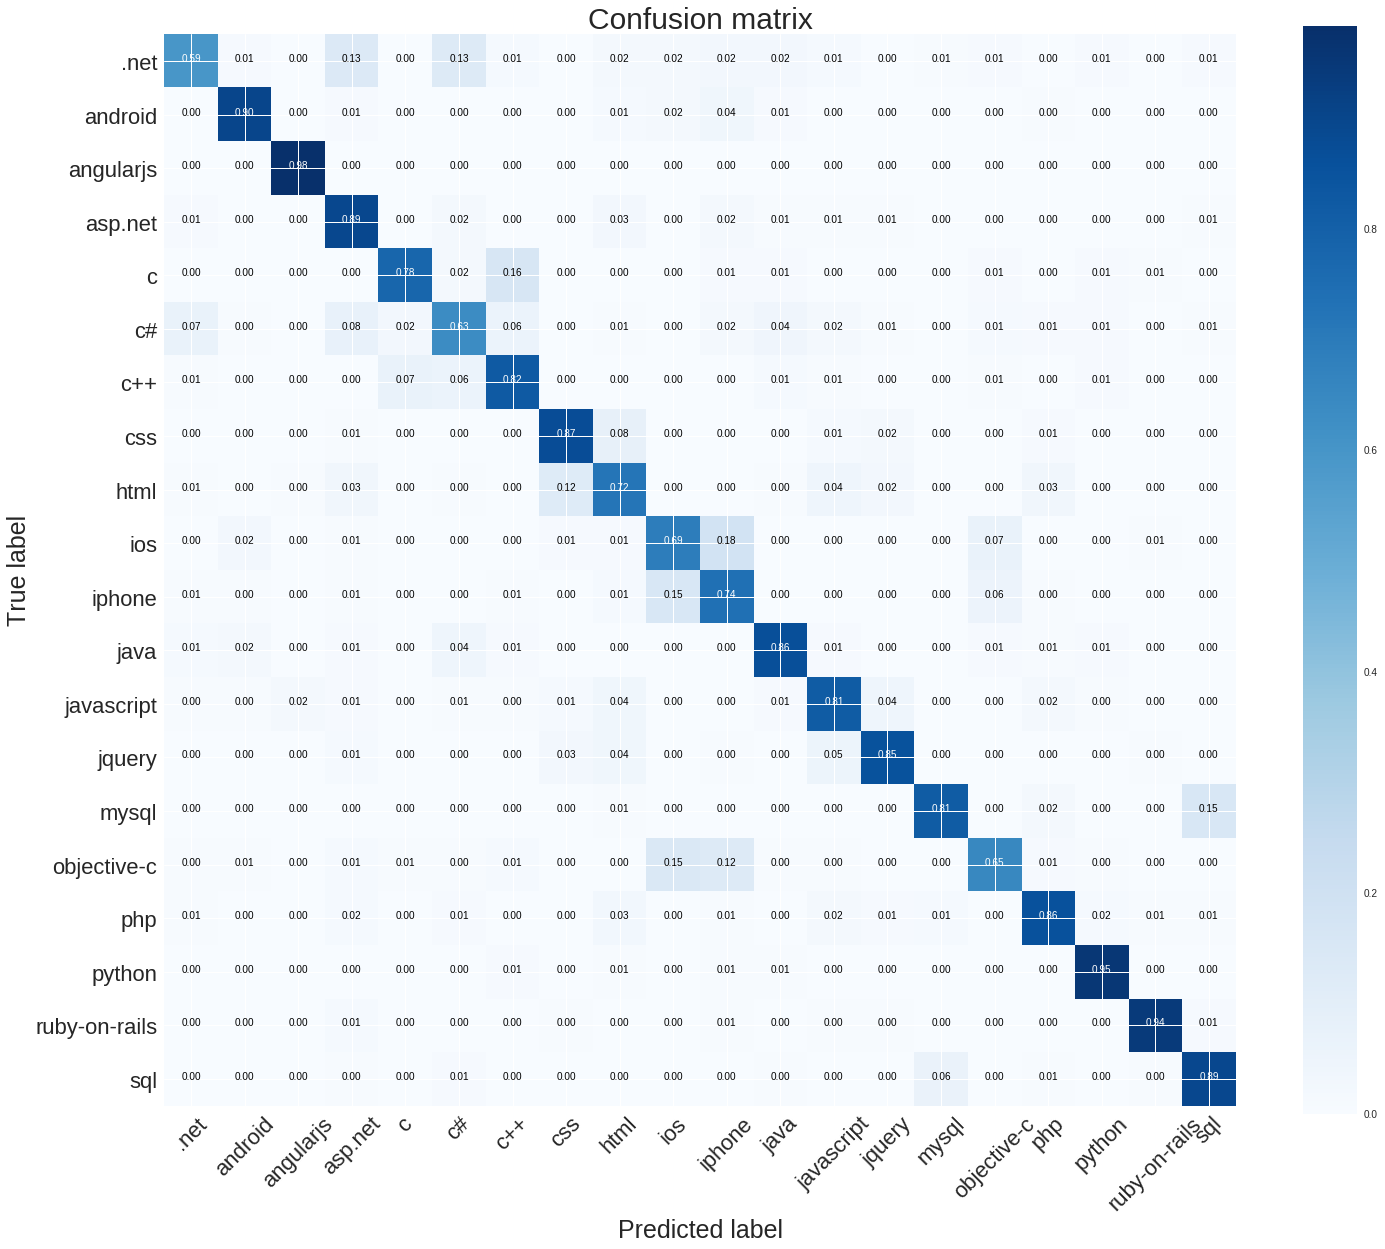

In [22]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## Generating predictions
We’ve built and trained a model and evaluated its accuracy, but we’re not quite done. Now that the model is trained, what if we want it to generate a prediction for a few examples?
Here we’ll pass our model 10 posts from our test set. All we need to do to generate predictions is call *predict()* on our model, passing it the post converted to a bag of words matrix:

In [23]:
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")  


jquery( tr_selector ) is removing the style values ...
Actual label:jquery
Predicted label: jquery

web reference in wcf  in wcf if we use webreferenc ...
Actual label:.net
Predicted label: asp.net

fragment transaction custom animation - android  i ...
Actual label:android
Predicted label: android

why can i not use the namespace directive in c++ s ...
Actual label:c++
Predicted label: c++

generating password reset link in c# .net  i must  ...
Actual label:.net
Predicted label: c#

php 5.3 $this versus php 5.4  i am calling a membe ...
Actual label:php
Predicted label: php

undefined method `request_uri  actiondispatch  i w ...
Actual label:ruby-on-rails
Predicted label: ruby-on-rails

my table view is not showing data  i am using a ta ...
Actual label:iphone
Predicted label: iphone

update panel not working correctly   i have added  ...
Actual label:asp.net
Predicted label: asp.net

floating objects in html  is it possible to make a ...
Actual label:html
Predicted label: html



Prediction is now a 1x20 array: 1 row for the individual question and 20 columns for the softmax probability that the question belongs to each tag. For this array of probabilities generated by our model, we want to get the index of the highest value, find the tag associated with that index from our LabelBinarizer, and output the question text and predicted label:

## Next Steps
This post introduced a simple way to represent Stack Overflow questions and build a model to classify them using the Keras API. Our emphasis here hasn’t been on accuracy. To improve that, we could experiment with various hyperparameters:
* Changing the vocab size the BOW model uses
* Changing batch size, number of epochs, or the dimensionality of the input layer
* Increasing the size of our training dataset
* Adding dropout to one of our layers to prevent the model from overfitting (done in above)

Remember that with bag of words, the model disregards the order of words in our text. Since the order of words in a question contributes to its meaning, this is probably something we want to preserve in our representation.